# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.705663,False,2.967907
1,1.231170,False,3.594875
2,0.420823,False,0.174293
3,-0.144315,False,-0.546638
4,-0.269736,True,2.830733
...,...,...,...
995,1.059536,True,9.365435
996,0.540831,False,1.125915
997,1.863398,True,10.618004
998,1.560471,False,3.999277


<AxesSubplot: xlabel='v0'>

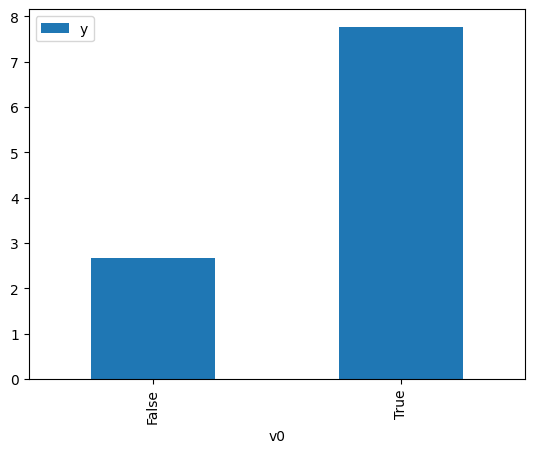

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

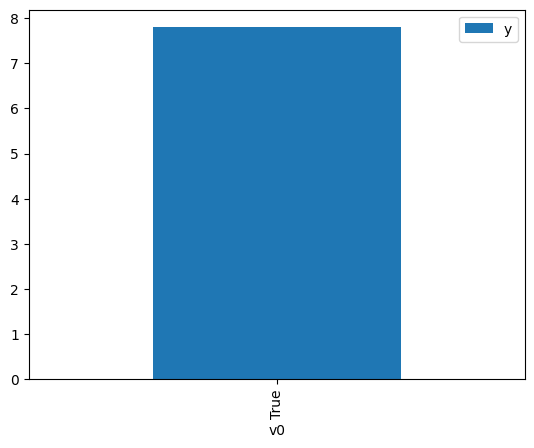

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.492526,False,-1.876781,0.487027,2.053275
1,0.778173,False,1.900353,0.426077,2.346995
2,1.221873,False,2.604180,0.405219,2.467799
3,1.650736,False,6.233594,0.385379,2.594850
4,0.064968,False,-0.537042,0.460130,2.173300
...,...,...,...,...,...
995,1.182737,False,3.787311,0.407047,2.456722
996,0.014787,False,1.398110,0.462544,2.161958
997,-0.078052,False,-0.894837,0.467014,2.141263
998,-1.561230,False,-5.771837,0.538664,1.856444


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.669864,True,5.912730,0.568789,1.758122
1,0.334673,True,6.343450,0.552809,1.808943
2,0.299525,True,5.505543,0.551127,1.814465
3,0.932158,True,6.693782,0.581196,1.720591
4,0.194685,True,6.309244,0.546101,1.831163
...,...,...,...,...,...
995,-0.260626,True,3.062064,0.524180,1.907743
996,0.646505,True,3.149339,0.567679,1.761558
997,1.944469,True,10.587631,0.627998,1.592361
998,2.336485,True,10.701574,0.645547,1.549074


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          2.561e+04
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                        0.00
Time:                        09:28:03   Log-Likelihood:                         -1386.1
No. Observations:                1000   AIC:                                      2776.
Df Residuals:                     998   BIC:                                      2786.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9435      0.027    108.953      0.000       2.890       2.996
x2             5.0208      0.049    103.458      0.000       4.926       5.116
==============================================================================
Omnibus:                        0.684   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.766
Skew:                          -0.030   Prob(JB):                        0.682
Kurtosis:                       2.878   Cond. No.                         2.43
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""